# Get prediction of the best model

This script is aimed to obtain from the results of the best model:
1. [Feature importance of each state model](#1.-Feature-importance-of-each-state)
    - [Check feature importance in all states](#1.1-Check-feature-importance-over-the-threshold-in-all-states)
    - [Plot feature importance for each state](#1.2-Save-feature-importance-for-each-state)
    - [Plot feature importance of all at once](#1.3-Plot-all-feature-importance-training-at-once)
2. [Predictions for 2023 and final metrics by state](#2.-Final-predictions-2023-and-metrics-by-state)

## Load packages

In [1]:
# Set Git path
import os 
CURRENT_PATH = os.getcwd()
import warnings

# data manipulation
import pandas as pd
import numpy as np
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=UserWarning)

# preprocessing
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tqdm import tqdm

## Load best model

In [7]:
best_data = pd.read_pickle('../01-Preprocessing/data/data.pkl')

mse_tr = pd.read_pickle('../02-Model/results/best_model/res/mse_train.pkl')
mae_tr = pd.read_pickle('../02-Model/results/best_model/res/mae_train.pkl')
prediction2023 = pd.read_pickle('../02-Model/results/best_model/res/predictions.pkl')

with open('../02-Model/results/best_model/res/model_per_state.pkl', 'rb') as f:
    best_model = pickle.load(f)

with open('../02-Model/results/best_model/res/data_per_state.pkl', 'rb') as f:
    data_state = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-28 19:50:50         4858
metadata.json                                  2023-04-28 19:50:50           64
variables.h5                                   2023-04-28 19:50:50      1748712
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...layers\leaky_re_lu
......vars
...layers\leaky_re_lu_1
......vars
...layers\leaky_re_lu_2
......vars
...layers\leaky_re_lu_3
......vars
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\lstm_2
......vars
...layers\lstm_2\cell
......vars
.........0


## 1. Feature importance of each state

In [6]:
if not os.path.exists('results/feature-importance-train'):
    os.makedirs('results/feature-importance-train')

Get the feature importance by the posth-hoc method of input perturbation

In [9]:
timesteps = 10
years_to_validate = 1
batch_size = 32
epochs = 5000
states = list(data_state.keys())
np.random.seed(1995) 

threshold = 2 #200% over baseline
features_best_model_tr = {}

for state in states: 

    model = best_model[state]
    data = data_state[state]

    # Scale and divide
    X = data.drop(['CORN - ACRES PLANTED'], axis=1)
    scaler = MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    scaler_y = MinMaxScaler()
    y = data['CORN - ACRES PLANTED']
    scaled_y = scaler_y.fit_transform(y.values.reshape(-1, 1))

    results = []
    print(' Computing LSTM feature importance...')

    # COMPUTE BASELINE (NO SHUFFLE)
    baseline_mse = mse_tr[state]
    results.append({'feature':'BASELINE','mse':baseline_mse})           

    for k in tqdm(range(len(X.columns))):
        
        # SHUFFLE FEATURE K
        save_col = scaled_X[:,k].copy()
        np.random.shuffle(scaled_X[:,k])

        # Create time series generator
        train_generator = TimeseriesGenerator(scaled_X[:-years_to_validate], scaled_y[:-years_to_validate], length=timesteps, sampling_rate=1, batch_size=batch_size)
                
        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        score = model.evaluate(train_generator, verbose=0)
        results.append({'feature':X.columns[k],'mse':score[0]})
        scaled_X[:,k] = save_col

    df = pd.DataFrame(results)
    df = df.sort_values('mse')
    features_best_model_tr[state] = df

 Computing LSTM feature importance...


100%|██████████| 22/22 [00:02<00:00, 10.59it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.75it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.41it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  7.46it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  8.33it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  7.71it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  8.26it/s]


 Computing LSTM feature importance...


100%|██████████| 22/22 [00:02<00:00,  8.71it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.39it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.02it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.17it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.90it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.86it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.16it/s]


 Computing LSTM feature importance...


100%|██████████| 18/18 [00:01<00:00, 10.53it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.99it/s]


 Computing LSTM feature importance...


100%|██████████| 18/18 [00:01<00:00, 10.46it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.73it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.74it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.58it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.78it/s]


 Computing LSTM feature importance...


100%|██████████| 18/18 [00:01<00:00, 10.67it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.92it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.40it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.33it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:03<00:00,  6.65it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 11.21it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  8.04it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.89it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.38it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.41it/s]


 Computing LSTM feature importance...


100%|██████████| 18/18 [00:01<00:00, 10.40it/s]


 Computing LSTM feature importance...


100%|██████████| 22/22 [00:01<00:00, 11.19it/s]


 Computing LSTM feature importance...


100%|██████████| 18/18 [00:01<00:00,  9.73it/s]


 Computing LSTM feature importance...


100%|██████████| 18/18 [00:01<00:00,  9.41it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 11.14it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 11.25it/s]


 Computing LSTM feature importance...


100%|██████████| 18/18 [00:01<00:00, 10.75it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:01<00:00, 10.97it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.47it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  8.85it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.69it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.09it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.84it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  8.84it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00, 10.40it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.68it/s]


 Computing LSTM feature importance...


100%|██████████| 21/21 [00:02<00:00,  9.24it/s]


### 1.1 Check feature importance over the threshold in all states

According with the **MSE in training**

In [12]:
# Get the features on each state that overpass the threshold

over_threshold = {state: pd.DataFrame(columns=features_best_model_tr[state].columns) for state in states}

for key, df in features_best_model_tr.items():
    for index, row in df.iterrows():
        if row['mse'] > df['mse'][0]*threshold:
            over_threshold[key] = over_threshold[key].append(row, ignore_index=True)

# Count how many times each of the features are important
all_features = []
for state_df in over_threshold.values():
    all_features += list(state_df['feature'])
unique_features = list(set(all_features))

feature_counts = pd.DataFrame({'feature': unique_features})
counts = []
for feature in unique_features:
    count = 0
    for state_df in over_threshold.values():
        if feature in list(state_df['feature']):
            count += 1
    counts.append(count)
feature_counts['counts'] = counts

feature_counts = feature_counts.sort_values('counts')

# Define mapping function
def color_mapper(feature):
    if feature == list(feature_counts.feature)[-1]:
        return '#40513B'
    elif feature == list(feature_counts.feature)[-2]:
        return '#609966'
    elif feature == list(feature_counts.feature)[-3]:
        return '#9DC08B'
    elif feature == list(feature_counts.feature)[-4]:
        return '#BFCCB5'
    elif feature == list(feature_counts.feature)[-5]:
        return '#EDF1D6'
    else:
        return '#D3D3D3'
colors = list(map(color_mapper, feature_counts.feature))


plt.figure(figsize=(20,10))
plt.barh(y=feature_counts.feature,width=feature_counts.counts, color=colors)
plt.title('Features over the threshold in all states', size=16)
plt.ylim((-1,len(X.columns)))
plt.xlabel(f'Counts of states with this feature as important',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
# Save the figure in the directory
plt.savefig('results/feature-importance-all-states.png',bbox_inches='tight')
plt.close()

C:\Users\Sara\AppData\Local\Temp\ipykernel_153980\3685540446.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  over_threshold[key] = over_threshold[key].append(row, ignore_index=True)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


### 1.2 Save feature importance for each state

In [25]:
# Plot only the ones that overpass the threshold and color the three top ones in general
for state in states:

    df = features_best_model_tr[state]
    bas_state = df[df['feature'] == 'BASELINE']['mse']
    # map colors from above
    colors = list(map(color_mapper, df.feature))
    if max(features_best_model_tr[state]['mse']+0.0005)>float(bas_state*threshold)+0.0005:
        max_x = max(features_best_model_tr[state]['mse']+0.0005)
    else:
        max_x = float(bas_state*threshold)+0.0005
    
# plot them
    plt.figure(figsize=(20,10))
    plt.barh(y=df.feature,width=df.mse, color=colors)
    plt.title(state, size=20)
    plt.ylim((-1,len(best_data.columns)+1))
    plt.xlim((0,max_x))
    plt.plot([bas_state*threshold,bas_state*threshold],[-1,len(best_data.columns)+1], '--', color='red',
                        label=f'Baseline * 2 \nThreshold MSE={baseline_mse*threshold:.3f}')
    plt.xlabel(f'MSE with feature permuted',size=14)
    plt.legend()
# Save the figure in the directory
    plt.savefig(os.path.join('results/feature-importance-train/', 'MSE_fi_' + state + '.png'),bbox_inches='tight')
    plt.close()

### 1.3 Plot all feature importance training at once

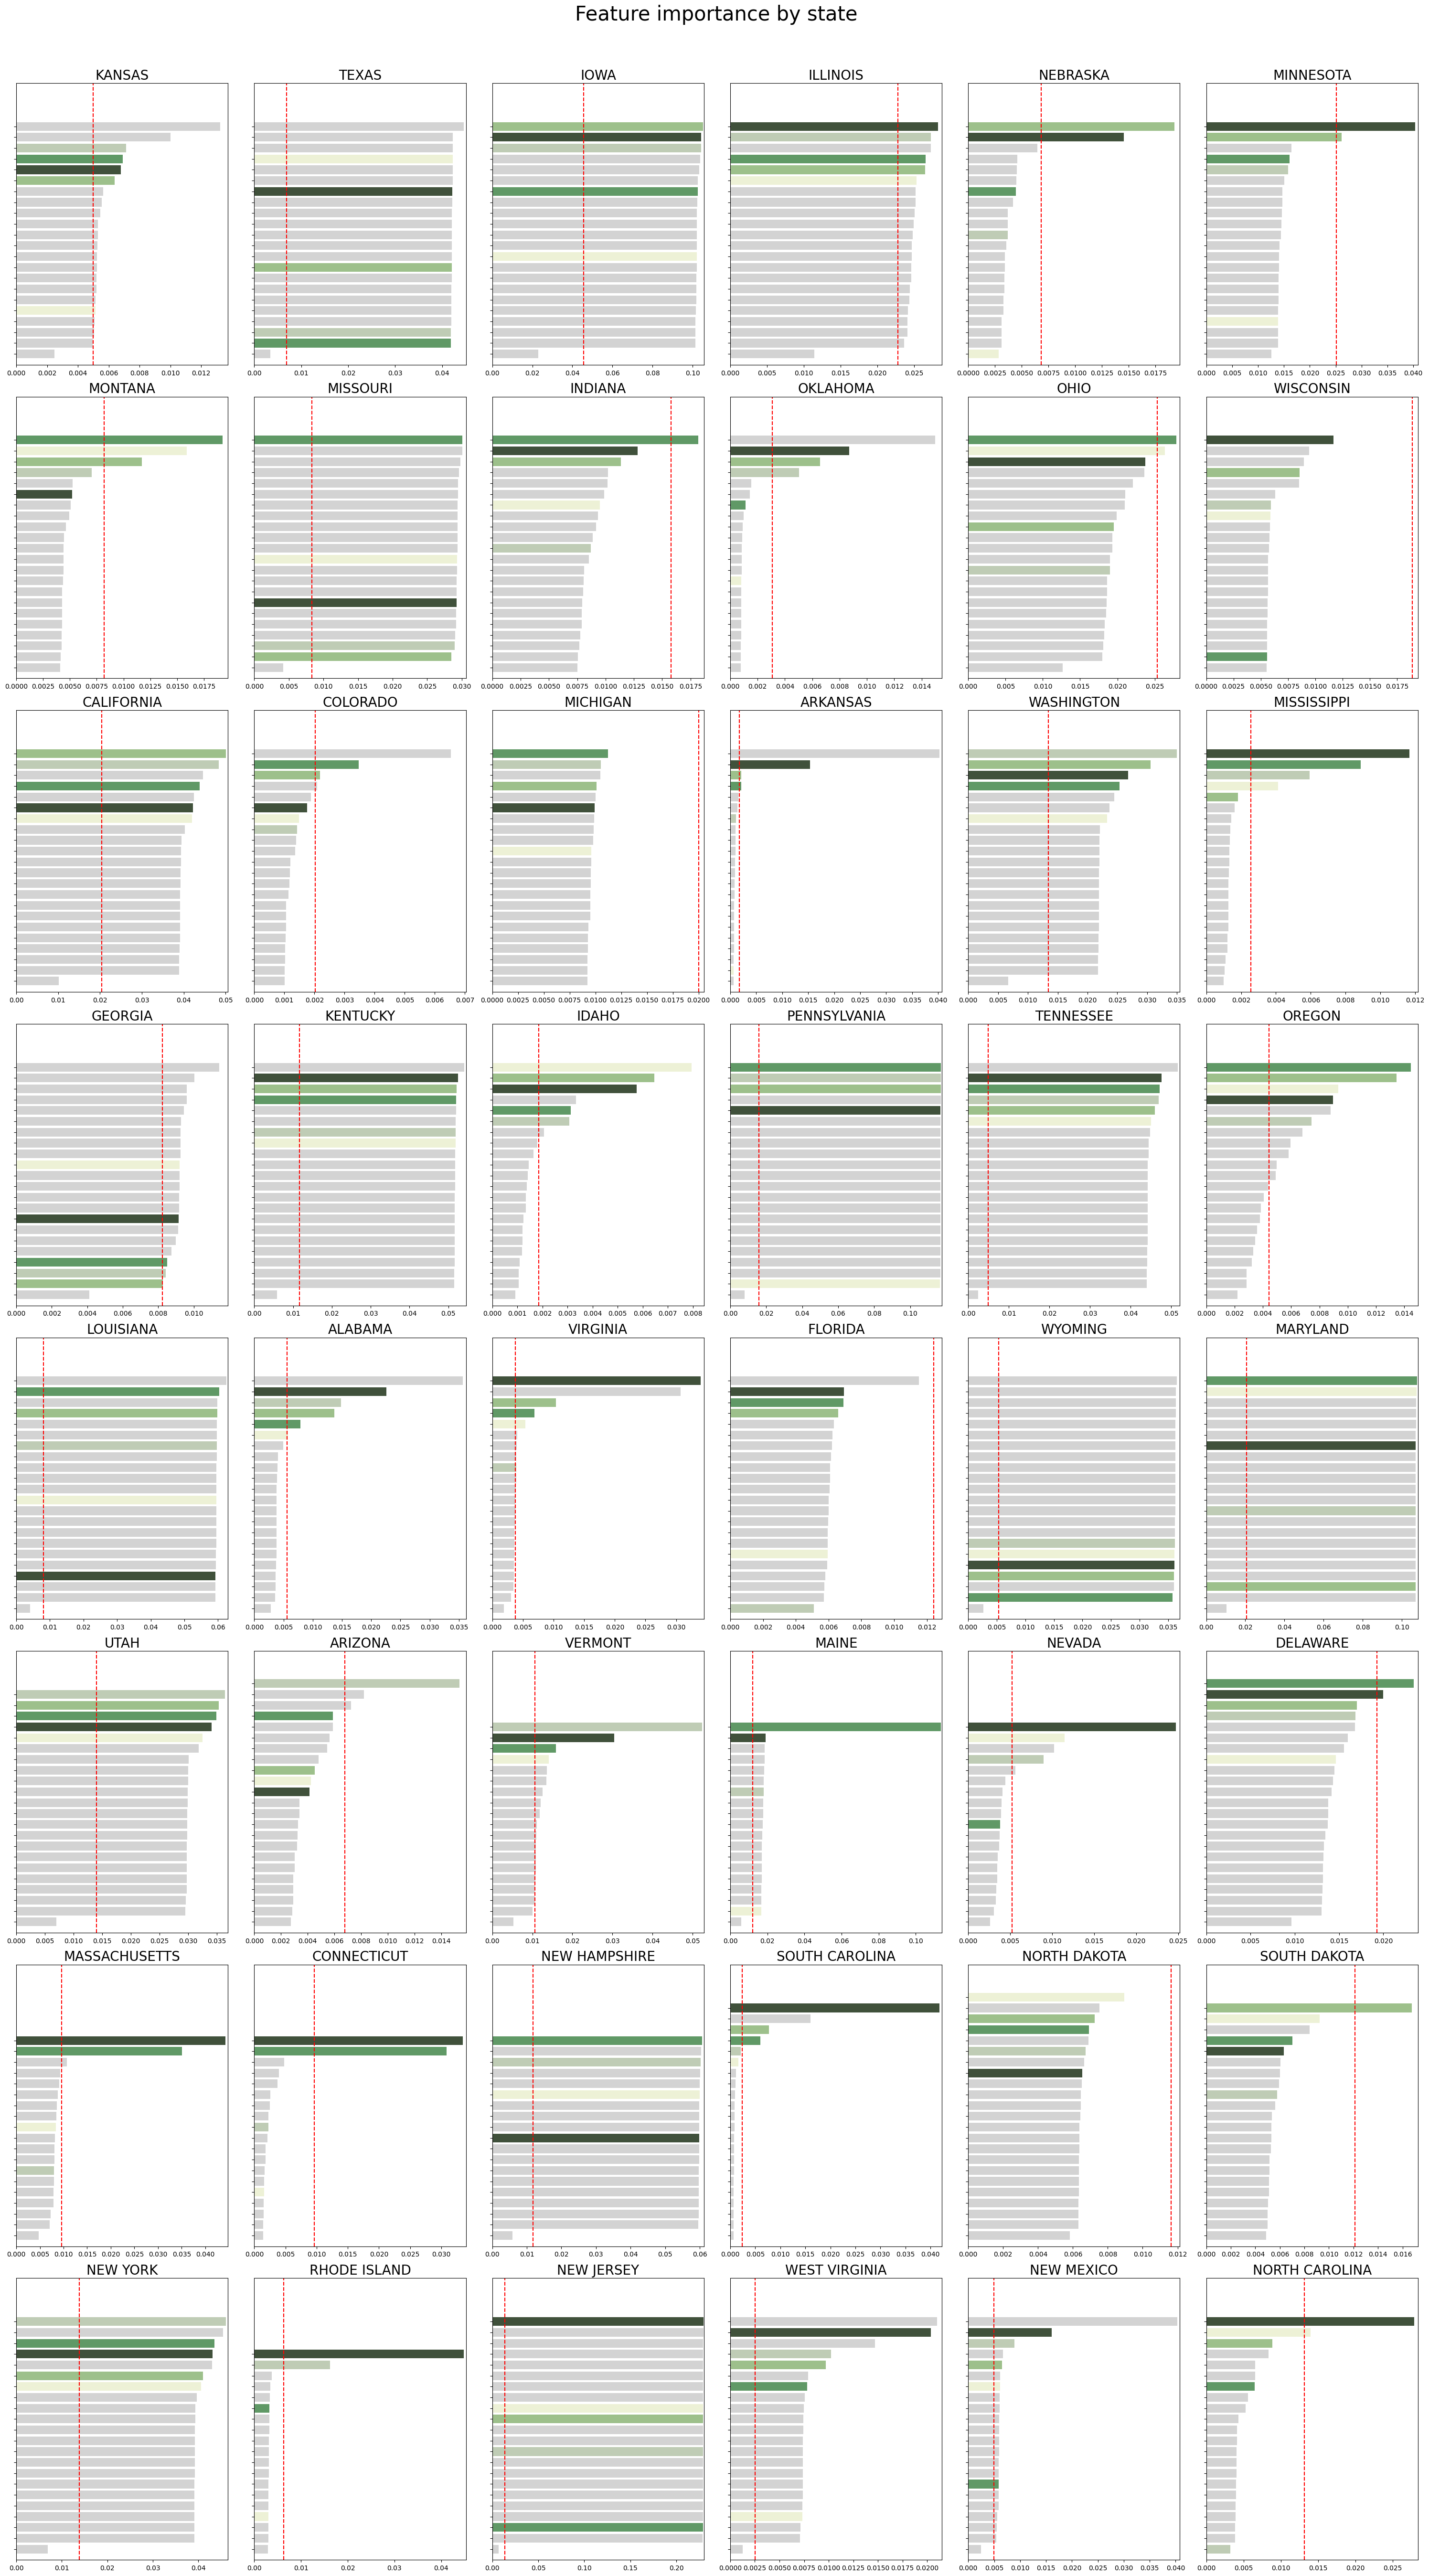

In [26]:
# Join all plots in one 
states_ordered_by_corn = ['KANSAS', 'TEXAS', 'IOWA', 'ILLINOIS', 'NEBRASKA', 'MINNESOTA',
                        'MONTANA', 'MISSOURI', 'INDIANA', 'OKLAHOMA', 'OHIO', 'WISCONSIN',
                        'CALIFORNIA', 'COLORADO', 'MICHIGAN', 'ARKANSAS', 'WASHINGTON',
                        'MISSISSIPPI', 'GEORGIA', 'KENTUCKY', 'IDAHO', 'PENNSYLVANIA',
                        'TENNESSEE', 'OREGON', 'LOUISIANA', 'ALABAMA', 'VIRGINIA',
                        'FLORIDA', 'WYOMING', 'MARYLAND', 'UTAH', 'ARIZONA', 'VERMONT',
                        'MAINE', 'NEVADA', 'DELAWARE', 'MASSACHUSETTS', 'CONNECTICUT']

states_ordered_by_corn = np.concatenate((np.array(states_ordered_by_corn), np.array(list(set(states) - set(states_ordered_by_corn)))))

# define subplot grid
fig, axs = plt.subplots(8, 6, figsize=(30, 55))
plt.subplots_adjust(hspace=0.75)
fig.suptitle("Feature importance by state", fontsize=30)

f = np.array([n for n in [0,1,2,3,4,5,6,7] for i in range(6)])
c = np.array([0,1,2,3,4,5]*8)

# Loop through the states and create a subplot for each state
for i, state in enumerate(states_ordered_by_corn):
    # Select the data for the current state
    df = features_best_model_tr[state]
    bas_state = df[df['feature'] == 'BASELINE']['mse']
    colors = list(map(color_mapper, df.feature))
    if max(features_best_model_tr[state]['mse']+0.0005)>float(bas_state*threshold)+0.0005:
        max_x = max(features_best_model_tr[state]['mse']+0.0005)
    else:
        max_x = float(bas_state*threshold)+0.0005

    # Create a horizontal bar plot of the MSE values for the current state
    axs[f[i], c[i]].barh(y=df.feature,width=df.mse, color=colors)
    axs[f[i], c[i]].set_ylim((-1,len(best_data.columns)+1))
    axs[f[i], c[i]].set_xlim((0,max_x))
    axs[f[i], c[i]].plot([bas_state*threshold,bas_state*threshold],[-1,len(best_data.columns)+1], '--', color='red')
    axs[f[i], c[i]].set_title(state, fontsize= 20)
    axs[f[i], c[i]].set_yticklabels([])

# Adjust the spacing between subplots
fig.tight_layout()
plt.subplots_adjust(top=0.95)

# Save the figure in the directory
plt.savefig('results/feature-importance-by-state.pdf',bbox_inches='tight')
# Display the plot
plt.show()
plt.close()

## 2. Final predictions 2023 and metrics by state

In [28]:
prediction2023 = pd.read_pickle('../02-Model/results/best_model/res/predictions.pkl')
pred_df = pd.DataFrame({'State': prediction2023.keys(), '2023 Corn Acres': prediction2023.values()})
metrics_train_df = pd.DataFrame({'State': mse_tr.keys(), 'MSE train': mse_tr.values(), 'MAE train': mae_tr.values()})

Order dataframes

In [29]:
# order both df
metrics_train_df = metrics_train_df.sort_values('State')
pred_df = pred_df.sort_values('State')

to_xls = {'Metrics train': metrics_train_df, 'Corn Acres in 2023 by state': pred_df}

Save them in one *.xlsx* file

In [30]:
writer = pd.ExcelWriter('results/best_model.xlsx', engine='xlsxwriter')
for sheetname, df in to_xls.items():  # loop through `dict` of dataframes
    df.to_excel(writer, sheet_name=sheetname, index=False)  # send df to writer
    worksheet = writer.sheets[sheetname]  # pull worksheet object
    for idx, col in enumerate(df):  # loop through all columns
        series = df[col]
        max_len = max((
            series.astype(str).map(len).max(),  # len of largest item
            len(str(series.name))  # len of column name/header
            )) + 1  # adding a little extra space
        worksheet.set_column(idx, idx, max_len)  # set column width
writer.save() 

C:\Users\Sara\AppData\Local\Temp\ipykernel_153980\3404542658.py:12: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
